In [27]:
'''
#Gigacow-tools# - data collection for good/bad memory.
This scripts used for single cow data collection work.
Data Tables: gigacow_filter.csv, lactation_filter.csv, traffic_raw_filter.csv
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


#access data from local directory
dataDir = Path.cwd().parent.parent.parent/'Data/processed'
gigacow_cols = ['Gigacow_Cow_Id', 'FarmName_Pseudo', 'BreedName', 'BirthDate']
lactation_cols = ['Gigacow_Cow_Id', 'FarmName_Pseudo', 'LactationInfoDate', 'LactationNumber', 'DaysInMilk']
gigacow = pd.read_csv(dataDir/'gigacow_filter.csv', encoding='utf-8', usecols=gigacow_cols)
lactation = pd.read_csv(dataDir/'lactation_filter.csv', encoding='utf-8', usecols=lactation_cols)
traffic = pd.read_csv(dataDir/'traffic_raw_filter.csv', encoding='utf-8', index_col=False)
#check out cows with most milking events
print(traffic.Gigacow_Cow_Id.value_counts().nlargest(10))

5613    11903
6197    11250
4478    11054
3757    10907
2423    10864
3147    10083
4504    10016
5147     9758
3121     9518
5046     9390
Name: Gigacow_Cow_Id, dtype: int64


In [29]:
# Select cows with sufficient data points on single lactation periods
# Try to collect cow's data that contain milking events on lactation periods 1
# fetch all milking traffic events for merging
traffic_milking = traffic.TrafficResult.str.contains('kg', regex=False)
all_list = traffic_milking.index[traffic_milking.values == True].tolist()
milking_total = traffic[traffic.index.isin(all_list)]
milking_total.TrafficEventDateTime = pd.to_datetime(milking_total.TrafficEventDateTime)
milking_total['milking_date'] = milking_total.TrafficEventDateTime.dt.date

# convert data type
milking_total.milking_date = pd.to_datetime(milking_total.milking_date)
lactation.LactationInfoDate = pd.to_datetime(lactation.LactationInfoDate)
# merge all milking events with lactation table for filtering
milking_total = milking_total.merge(lactation, how='left', left_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'milking_date'], right_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'LactationInfoDate'])

def lac_collect(NumLac, milking_total):
    """Generate dataset with config.

    Args:
        NumLac: The number of lactaion period
        milking_total: A dataframe contains all the milkings events

    Returns:
        A list contain all the cows events with sufficient data points within the lactation periods.
    """
    cow_list = list()
    for num in range(1, NumLac+1):
        # select records that contains lactation period #num
        milking_select1 = milking_total.loc[milking_total['LactationNumber'] == num]
        milking_select1.drop_duplicates(subset=['Gigacow_Cow_Id', 'milking_date', 'LactationNumber', 'DaysInMilk'], inplace=True)
        # drop the anomaly data point
        milking_select1 = milking_select1.loc[milking_select1.DaysInMilk < 400]
        # select sufficient data points on lactation 1
        selected1 = milking_select1.Gigacow_Cow_Id.value_counts(ascending=True)
        selected1 = selected1.loc[(selected1.values > 80) & (selected1.values < 365)]
        selected_cow_list = selected1.index.to_list()
        if num == 1:
            cow_list = selected_cow_list
        cow_list = list(set(cow_list) & set(selected_cow_list))
        print(len(cow_list), cow_list)
    return cow_list

cow_list = lac_collect(2, milking_total)
#cow_list = [3718, 2569, 1555, 5147, 1181, 926, 5160, 182, 5046, 1985, 1738, 74, 1103, 478, 5088, 5092, 2278, 6380, 2423, 3707]

116 [2560, 3075, 2569, 4109, 1551, 3603, 1555, 5147, 3613, 544, 5160, 2090, 560, 3638, 3657, 74, 1103, 4176, 2135, 90, 4704, 6241, 4195, 4200, 622, 5235, 3705, 3707, 2694, 5767, 3718, 2702, 151, 2712, 4765, 1181, 3744, 2724, 6316, 3762, 5301, 182, 702, 708, 4295, 5322, 2251, 1738, 6351, 1744, 5844, 5846, 4311, 5848, 6360, 1244, 5852, 1247, 2278, 2792, 6380, 5873, 2805, 4341, 769, 1796, 2844, 4899, 3890, 1336, 5948, 5442, 2374, 6472, 4939, 5965, 855, 5465, 1905, 3446, 3447, 2423, 4988, 4990, 385, 6018, 3979, 3468, 2956, 919, 2460, 926, 3487, 2979, 4525, 943, 5555, 5046, 951, 4537, 961, 1985, 6086, 4038, 2510, 5076, 985, 478, 5088, 5092, 3563, 6127, 2031, 5616, 2039, 2047]
34 [3718, 2569, 1555, 3603, 919, 2712, 5147, 1181, 926, 5160, 560, 5555, 3638, 182, 5046, 5948, 1985, 5442, 74, 1738, 1103, 6351, 5844, 6360, 5848, 90, 478, 5088, 5092, 2278, 6380, 2031, 2423, 3707]


In [30]:
def countCowAge(birthDate, milkingDate):
    '''
    func: Calculate cows age based on birthDate and milkingDate
    args: 
        birthDate: cow's birth datetime
        milkingDate: milking events datetime
    return: cow age in human years(float)
    '''
    birthDate = pd.to_datetime(birthDate)
    milkingDate = pd.to_datetime(milkingDate)
    days = np.float32(np.datetime64(milkingDate, 'D') - np.datetime64(birthDate, 'D'))
    age = np.around(days/365, 2)
    return age

    #select single cow from the traffic table

def data_collector(traffic, gigacow, lactation, cow_id):

    traffic_single_cow = traffic.loc[traffic['Gigacow_Cow_Id'] == cow_id]
    traffic_single_cow.sort_values(by='TrafficEventDateTime', inplace=True)
    traffic_single_cow.index = range(len(traffic_single_cow))

    '''
        Extract Milking Event and its most recent traffic event to calculate T2-T1
        T1: Entry time into the Mjolkfalla
        T2: Entry time into the milking robot
        T2-T1: calculate time difference between T2&T1 (i.e., Time spend in Mjolkfalla/holding area)
    '''
    # locate mikling event by searching 'kg' keyword in traffic result
    # the most recent traffic event to milking event should be pre_milking event
    # need to filter out records with gate failure
    track_milking = traffic_single_cow.TrafficResult.str.contains('kg', regex=False)
    milking_index_list = track_milking.index[track_milking.values == True].tolist()
    pre_milking_index_list = [x-1 for x in milking_index_list]
    milking_traffic = traffic_single_cow[traffic_single_cow.index.isin(milking_index_list)]
    pre_milking_traffic = traffic_single_cow[traffic_single_cow.index.isin(pre_milking_index_list)]

    # drop rows that the gate failed to detect cows but have milking result
    # previous area in milking_traffic table should only be Mjolkfalla
    # previous area in pre_milking_traffic table should not be Mjolkfalla
    failed_list_1_milk = milking_traffic.index[milking_traffic['PreviousArea'] == 'Koridor till Sorteringsgrind 2'].tolist()
    failed_list_1_pre = [x-1 for x in failed_list_1_milk]
    failed_list_2_pre = pre_milking_traffic.index[pre_milking_traffic['PreviousArea'] == 'Mjolkfalla'].tolist()
    failed_list_2_milk = [x+1 for x in failed_list_2_pre]
    # traffic result in pre_milking_traffic table should contain Mjolkfalla
    track_pre_milking = pre_milking_traffic.TrafficResult.str.contains('Mjolkfalla', regex=False)
    failed_list_3_pre = track_pre_milking.index[track_pre_milking.values == False].tolist()
    failed_list_3_milk = [x+1 for x in failed_list_3_pre]

    # remove failed records based on index list
    milking_traffic_failed = failed_list_1_milk + failed_list_2_milk + failed_list_3_milk
    pre_milking_traffic_failed = failed_list_1_pre + failed_list_2_pre + failed_list_3_pre
    milking_traffic.drop(axis=0, index=milking_traffic_failed, inplace=True)
    pre_milking_traffic.drop(axis=0, index=pre_milking_traffic_failed, inplace=True)
    # concatenate two tables to track the traffic directly
    all_milking_traffic = pd.concat([milking_traffic, pre_milking_traffic])
    all_milking_traffic.sort_values(by=['TrafficEventDateTime'], inplace=True)
    #rename table columns for merging
    milking_traffic.rename(columns={"TrafficEventDateTime": "MilkingEventDateTime", "TrafficResult": "MilkProduction", "TimeInArea_totalSeconds": "RoundedSecondsTimeInArea"}, inplace=True)
    pre_milking_traffic.rename(columns={"TrafficEventDateTime": "Pre_MilkingEventDateTime", "TimeInArea_totalSeconds": "RoundedSecondsTimeInArea"}, inplace=True)
    # unify the index of two tables
    milking_traffic.index = range(len(milking_traffic))
    pre_milking_traffic.index = range(len(pre_milking_traffic))
    # inert "pre_traffic_milking" to milking traffic table
    milking_traffic.insert(5, 'Pre_MilkingEventDateTime', pre_milking_traffic['Pre_MilkingEventDateTime'])
    # calculate T2-T1
    milking_traffic.MilkingEventDateTime = pd.to_datetime(milking_traffic.MilkingEventDateTime)
    milking_traffic.Pre_MilkingEventDateTime = pd.to_datetime(milking_traffic.Pre_MilkingEventDateTime)
    milking_traffic['timeDelta_Seconds'] = (milking_traffic['MilkingEventDateTime'] - milking_traffic['Pre_MilkingEventDateTime']).dt.total_seconds()

    #extract traffic result(milk production)
    milking_traffic['MilkProduction'].replace(r"[^0-9.,]+"," ", inplace=True, regex=True)
    milking_traffic['MilkProduction'].replace(r"\s*","", inplace=True, regex=True)
    milking_traffic['MilkProduction'].replace(r"[,]+",".", inplace=True, regex=True)
    milking_traffic['MilkProduction'] = milking_traffic['MilkProduction'].astype('float64')

    # merge all the other features into milking_traffic table
    milking_traffic['MilkingDate'] = milking_traffic.MilkingEventDateTime.dt.date
    milking_traffic.MilkingDate = pd.to_datetime(milking_traffic.MilkingDate)
    lactation.LactationInfoDate = pd.to_datetime(lactation.LactationInfoDate)
    single_cow_merge = milking_traffic.merge(lactation, how='left', left_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'MilkingDate'], right_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'LactationInfoDate'])
    single_cow_merge = single_cow_merge.merge(gigacow, how='left', left_on=['FarmName_Pseudo', 'Gigacow_Cow_Id'], right_on=['FarmName_Pseudo', 'Gigacow_Cow_Id'])

    # drop failed data points based on RoundedSecondsTimeInArea & timeDelta_Seconds
    single_cow_merge.drop(single_cow_merge.loc[abs(single_cow_merge.timeDelta_Seconds - single_cow_merge.RoundedSecondsTimeInArea) > 300].index, inplace=True)
    single_cow_merge['TrafficDeviceName'].replace(r"[A-Za-z]+\s*","vms", inplace=True, regex=True)
    #calculate age of cows
    single_cow_merge['Age'] = single_cow_merge.apply(lambda x: countCowAge(x['BirthDate'], x['MilkingEventDateTime']), axis=1)
    single_cow_merge.drop(['BirthDate'], axis=1, inplace=True)

    return single_cow_merge

<Figure size 432x288 with 0 Axes>

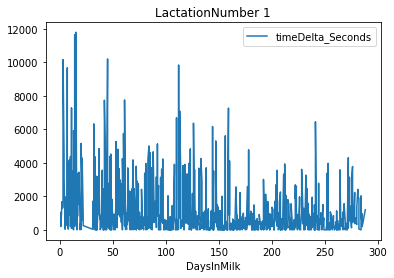

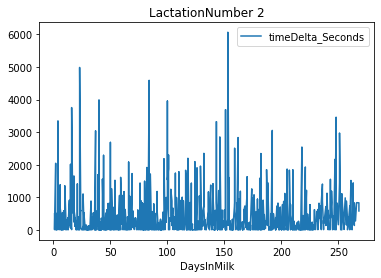

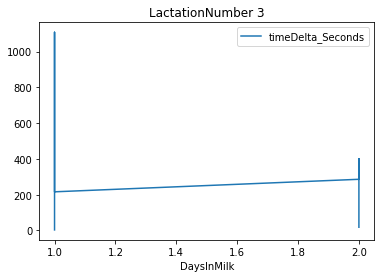

In [31]:
# plot the relations between timeDielta and Lactation/DIM(DaysInMilk)
single_cow_merge = data_collector(traffic, gigacow, lactation, 478)
plt.figure()
single_cow_merge.loc[single_cow_merge.LactationNumber == 1].plot(x="DaysInMilk", y="timeDelta_Seconds", kind='line', title='LactationNumber 1')
single_cow_merge.loc[single_cow_merge.LactationNumber == 2].plot(x="DaysInMilk", y="timeDelta_Seconds", kind='line', title='LactationNumber 2')
single_cow_merge.loc[single_cow_merge.LactationNumber == 3].plot(x="DaysInMilk", y="timeDelta_Seconds", kind='line', title='LactationNumber 3')
plt.show()


C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_17740\2338339369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_single_cow.sort_values(by='TrafficEventDateTime', inplace=True)
C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_17740\2338339369.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  milking_traffic.drop(axis=0, index=milking_traffic_failed, inplace=True)
C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_17740\2338339369.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

<Figure size 432x288 with 0 Axes>

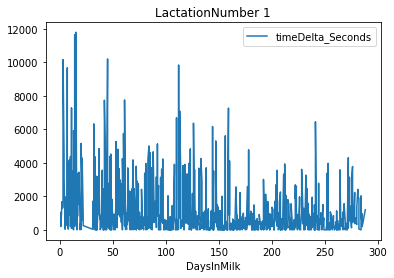

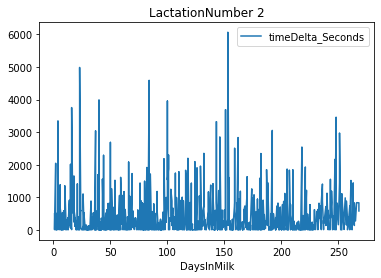

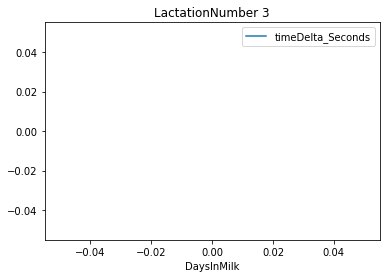

In [7]:
# plot the relations between timeDielta and Lactation/DIM(DaysInMilk)
periods = [1, 2]
single_cow_merge = data_collector(traffic, gigacow, lactation, 478)
single_cow_merge = single_cow_merge.loc[single_cow_merge.LactationNumber.isin(periods)]
plt.figure()
single_cow_merge.loc[single_cow_merge.LactationNumber == 1].plot(x="DaysInMilk", y="timeDelta_Seconds", kind='line', title='LactationNumber 1')
single_cow_merge.loc[single_cow_merge.LactationNumber == 2].plot(x="DaysInMilk", y="timeDelta_Seconds", kind='line', title='LactationNumber 2')
single_cow_merge.loc[single_cow_merge.LactationNumber == 3].plot(x="DaysInMilk", y="timeDelta_Seconds", kind='line', title='LactationNumber 3')
plt.show()


In [7]:
single_cow_merge
# single_cow_merge.loc[single_cow_merge.LactationNumber == 1].to_csv()

,Traffic_Id,FarmName_Pseudo,Gigacow_Cow_Id,GroupName,MilkingEventDateTime,Pre_MilkingEventDateTime,PreviousArea,RoundedSecondsTimeInArea,TrafficDeviceName,MilkProduction,MilkingInterval_totalSeconds,timeDelta_Seconds,MilkingDate,LactationInfoDate,LactationNumber,DaysInMilk,BreedName,Age
0,1393564,a624fb9a,478,VMS 1,2020-10-21 09:24:17,2020-10-21 09:06:55,Mjolkfalla,1020,vms2,3.08,NaN,1042.0,2020-10-21,2020-10-21,1,1.0,1,1.91
1,2235251,a624fb9a,478,VMS 1,2020-10-21 19:06:33,2020-10-21 19:03:03,Mjolkfalla,180,vms2,3.38,34380.0,210.0,2020-10-21,2020-10-21,1,1.0,1,1.91
2,5928162,a624fb9a,478,VMS 1,2020-10-22 05:52:24,2020-10-22 05:24:18,Mjolkfalla,1680,vms2,6.53,38340.0,1686.0,2020-10-22,2020-10-22,1,2.0,1,1.91
3,6628705,a624fb9a,478,VMS 1,2020-10-22 15:58:42,2020-10-22 15:36:58,Mjolkfalla,1260,vms1,5.00,35940.0,1304.0,2020-10-22,2020-10-22,1,2.0,1,1.91
4,407284,a624fb9a,478,VMS 1,2020-10-23 02:06:03,2020-10-23 01:43:44,Mjolkfalla,1320,vms2,7.16,36060.0,1339.0,2020-10-23,2020-10-23,1,3.0,1,1.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1669,8202645,a624fb9a,478,VMS 1,2022-06-26 17:18:21,2022-06-26 17:04:27,Mjolkfalla,780,vms1,9.65,42180.0,834.0,2022-06-26,2022-06-26,2,264.0,1,3.59
1670,10629298,a624fb9a,478,VMS 1,2022-06-27 03:55:22,2022-06-27 03:50:43,Mjolkfalla,240,vms1,7.10,37860.0,279.0,2022-06-27,2022-06-27,2,265.0,1,3.59
1671,3615124,a624fb9a,478,VMS 1,2022-06-28 17:19:34,2022-06-28 17:05:34,Mjolkfalla,840,vms1,13.75,NaN,840.0,2022-06-28,2022-06-28,2,266.0,1,3.59
1672,1048466,a624fb9a,478,VMS 1,2022-06-30 13:52:36,2022-06-30 13:38:40,Mjolkfalla,780,vms1,12.20,NaN,836.0,2022-06-30,2022-06-30,2,268.0,1,3.60


In [33]:
pd.options.mode.chained_assignment = None

# fetch enough data points from lactation period 1&2
periods = [1, 2]
mean_totalTimeCost_1 = 0
mean_totalTimeCost_2 = 0
Path(dataDir/'memory_targetCows').mkdir(parents=True, exist_ok=True)
for p in periods:
    Path(dataDir/'memory_targetCows'/str(p)).mkdir(parents=True, exist_ok=True)

# save target cows tables to directory
for i, cow_id in enumerate(cow_list):
    single_cow_merge = data_collector(traffic, gigacow, lactation, cow_id)
    single_cow_merge = single_cow_merge.loc[single_cow_merge.LactationNumber.isin(periods)]
    single_cow_merge.sort_values(by="MilkingEventDateTime", inplace=True)
    timecost_1 = single_cow_merge.loc[single_cow_merge.LactationNumber == 1].timeDelta_Seconds.mean()
    timecost_2 = single_cow_merge.loc[single_cow_merge.LactationNumber == 2].timeDelta_Seconds.mean()
    # calculate the timecost reduction percentage
    mean_totalTimeCost_1 += timecost_1
    mean_totalTimeCost_2 += timecost_2
    print("cow_" + str(cow_id))
    print(timecost_1)
    print(timecost_2)
    diff = (timecost_1-timecost_2)/timecost_1
    print(diff)
    # threshold setting to obtain balanced dataset
    # label the data (1: good memory, 0: bad memory)
    # for threshold=50%
    if(diff > 0.45):
        print("good")
        single_cow_merge["label"] = 1
    else:
        single_cow_merge["label"] = 0
    single_cow_merge["id"] = i+1
    single_cow_merge.dropna(inplace=True)
    for p in periods:
        fileName = 'memory_targetCows/' + str(p) + '/cow_' + str(i) + '.csv'
        single_cow_merge.loc[single_cow_merge.LactationNumber == p].to_csv(dataDir/fileName)
    #fileName = 'memory_targetCows/cow_' + str(i) + '.csv'
    #single_cow_merge.to_csv(dataDir/fileName, index=False)
        
print("num of cows: ", len(cow_list))
print("Mean of total time cost at lactation period 1: ", mean_totalTimeCost_1/len(cow_list))
print("Mean of total time cost at lactation period 2: ", mean_totalTimeCost_2/len(cow_list))

cow_3718
827.3369330453563
453.1363636363636
0.4522952553702546
good
cow_2569
322.80102040816325
258.60021905805036
0.1988866121579625
cow_1555
799.4668989547039
465.64148816234496
0.41756001559143074
cow_3603
1872.1141732283465
1743.4449152542372
0.06872938617425615
cow_919
1464.4691943127962
849.9974489795918
0.41958666506573117
cow_2712
762.15953307393
475.82593457943926
0.3756872230406336
cow_5147
653.2017220172202
303.9646910466583
0.5346541798635293
good
cow_1181
1462.5687984496124
755.6945564516129
0.4833100793257161
good
cow_926
933.9160104986877
529.891823899371
0.43261297810236476
cow_5160
602.0058892815076
498.56534954407294
0.17182645814460498
cow_560
829.9863945578231
467.25849514563106
0.4370287293750593
cow_5555
1177.4604105571848
1881.7627118644068
-0.5981537001094923
cow_3638
1039.6613924050632
1305.2162162162163
-0.25542433887714283
cow_182
1214.774193548387
754.4289439374185
0.3789554075612095
cow_5046
762.938440492476
361.2729145211122
0.5264717369753831
good
cow_59